# Imports and GPU Setup

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import os

from pytorch_msssim import SSIM, MS_SSIM
from models.trained_models.unet_wavelet import UNetWavelet
from torchsummary import summary
from skimage.metrics import structural_similarity

from utils.image_helpers import plot_image_grid, get_images, load_image, rgb2gray, show_images, image_to_tensor, tensor_to_image
from simulation.Simulation import Simulation
from models.model_creation import create_model_from_configuration
from fitting.Fitter import create_fitter_from_configuration
from fitting.Result import generate_rudimentary_result
from utils.configuration_parser.fit_model_configuration import get_fit_model_configuration

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    os.environ['CUDA_VISIBLE_DEVICES'] = '2'
    print("num GPUs",torch.cuda.device_count())
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor

num GPUs 1


# Load & Simulate Images

Number of Images: 6 in data/mri_scan


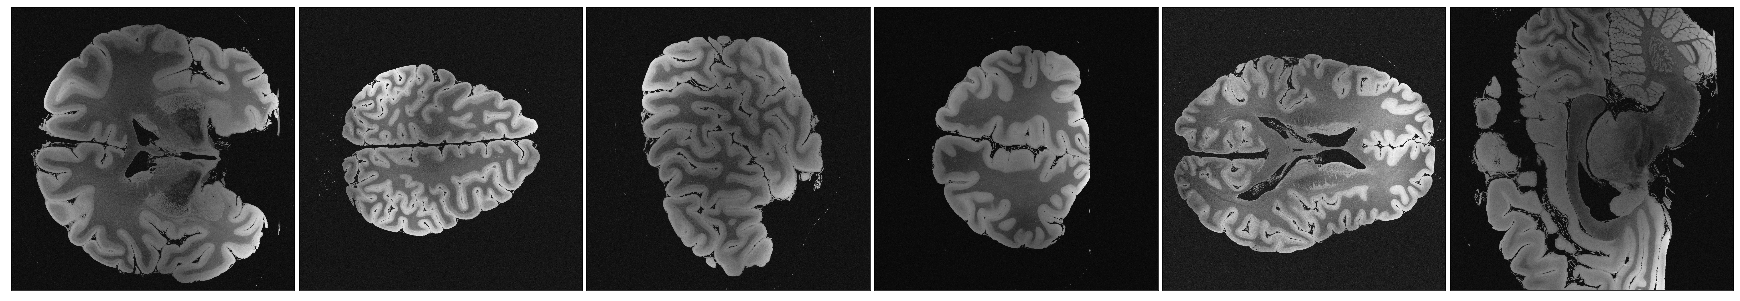

In [2]:
number_of_images = 6
original_images = get_images('data/mri_scan', max_amount=number_of_images, size=4096)

plot_image_grid(original_images, ncols=6)
plt.show()

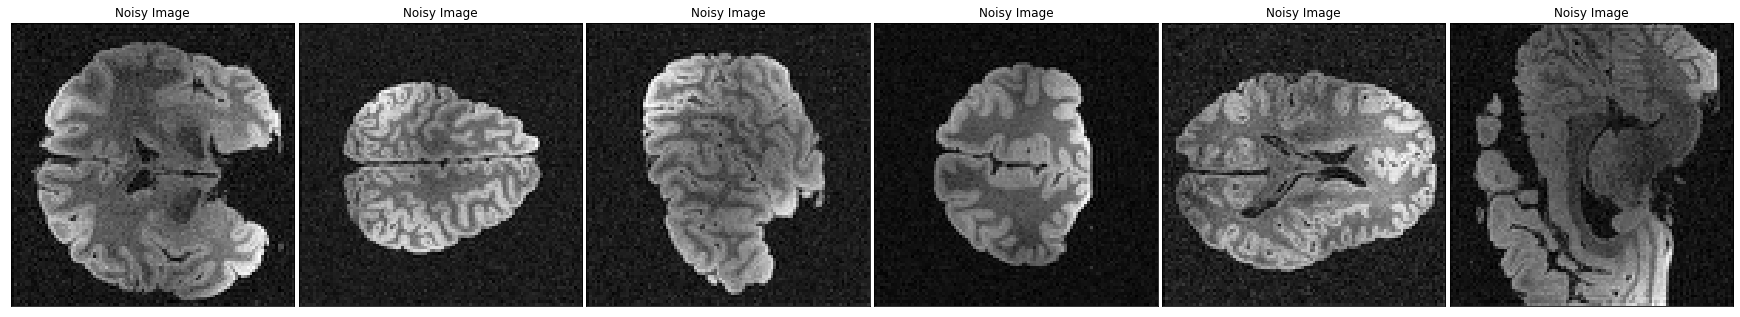

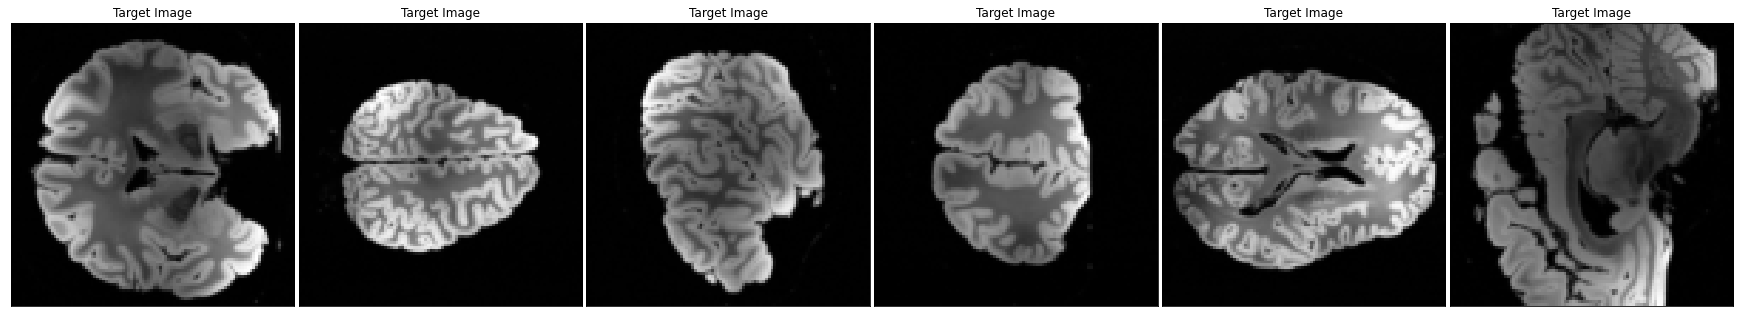

In [3]:
input_size = original_images[0].shape
cropped_size = (100, 100)
snr_range = (3,3)
pf_factor = 8

pipeline = Simulation(input_size=input_size, cropped_size=cropped_size, snr_range=snr_range, pf_factor=pf_factor)
noisy_images, target_images = pipeline.simulate_list_of_images(original_images)

plot_image_grid(noisy_images, ['Noisy Image']*number_of_images, ncols=number_of_images)
plot_image_grid(target_images, ['Target Image']*number_of_images, ncols=number_of_images)
plt.show()

# Apply Deep Decoder

In [4]:
fit_model_configuration = get_fit_model_configuration()
fit_model_configuration.image_dimensions = list(cropped_size) + [1]
fit_model_configuration.log_frequency = 100
fit_model_configuration.number_of_iterations = 3000
fit_model_configuration.convergence_check_length = None

fit_model_configuration.input_shape = [14, 14]
fit_model_configuration.number_of_layers = 5
fit_model_configuration.number_of_hidden_channels = 40

fit_model_configuration.find_best = True
fit_model_configuration.save_losses = False

print(fit_model_configuration)

image_dimensions: [100, 100, 1]  
result_path: data/results/  
model_type: deep  
input_shape: [14, 14]  
number_of_layers: 5  
number_of_hidden_channels: 40  
number_of_iterations: 3000  
learning_rate: 0.1  
convergence_check_length: None  
log_frequency: 100  
find_best: True  
save_losses: False  
constant_input: False  
data_type: <class 'torch.cuda.FloatTensor'>  



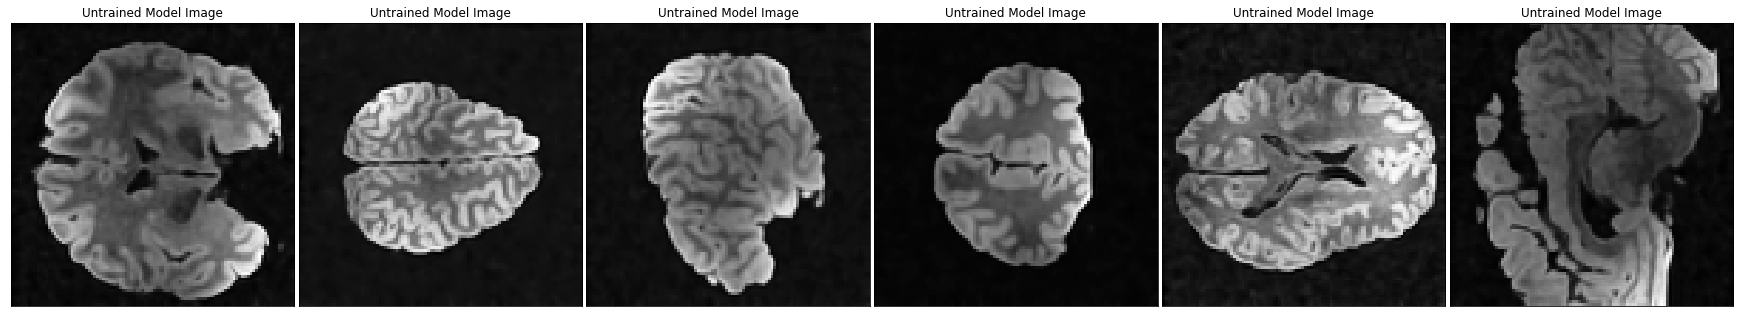

In [5]:
number_of_iterations = 20

untrained_model_images = []
for image_index, noisy_image in enumerate(noisy_images):
    iteration_images = []
    fitter = create_fitter_from_configuration(fit_model_configuration)
    for iteration_index in range(number_of_iterations):
        model = create_model_from_configuration(fit_model_configuration)
        log_prefix=f'Image {image_index+1}/{number_of_images}, Iteration {iteration_index+1}/{number_of_iterations}: '
        fitter(model, noisy_image, log_prefix=log_prefix)
        iteration_images.append(fitter.get_best_image())
    untrained_model_images.append(np.mean(iteration_images, axis=0))

plot_image_grid(untrained_model_images, ['Untrained Model Image'] * number_of_images, ncols=number_of_images)
plt.show()

# Load & Apply Trained Model

In [6]:
path = 'models/trained_models/unet_magintude_pffact_8_snrlog0-5_nlayers_10.pt'
trained_model = UNetWavelet(in_ch=1, out_ch=1)
trained_model.load_state_dict(torch.load(path))
trained_model = trained_model.type(dtype)
trained_model = trained_model.eval()
for param in trained_model.parameters():
    param.requires_grad = False
#print(list(trained_model.parameters())[0].shape)
#summary(trained_model, (1, 100, 100), dtypes=[torch.cuda.FloatTensor], depth=3)

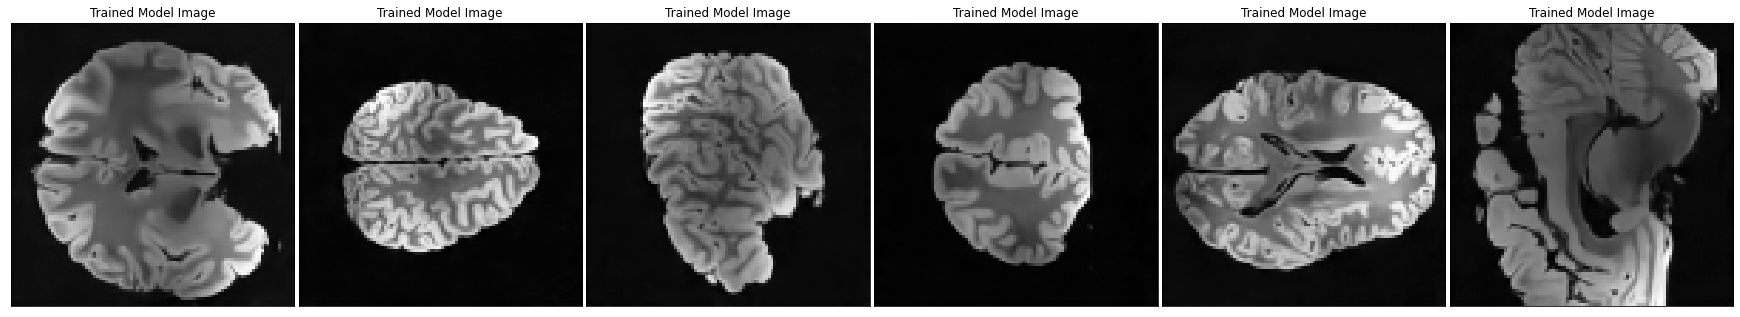

In [7]:
trained_model_images = []
for noisy_image in noisy_images:
    noisy_tensor = image_to_tensor(noisy_image).unsqueeze(0).type(dtype)
    trained_image = trained_model(noisy_tensor)
    trained_model_image = tensor_to_image(trained_image.cpu().squeeze(0))
    trained_model_images.append(trained_model_image)

plot_image_grid(trained_model_images, ['Trained Model Image'] * number_of_images, ncols=number_of_images)
plt.show()

# Calculate & Compare Results

In [8]:
trained_results = []
untrained_results = []
noisy_results = []
for (noisy, target, trained, untrained) in zip(noisy_images, target_images, trained_model_images, untrained_model_images):
    trained_results.append(generate_rudimentary_result('trained', noisy, trained, target))
    untrained_results.append(generate_rudimentary_result('untrained', noisy, untrained, target))
    noisy_results.append(generate_rudimentary_result('noisy', noisy, noisy, target))

/workspace/DiffusionMRI/fitting/Result.py:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  self.psnr = peak_signal_noise_ratio(target_image, model_image)


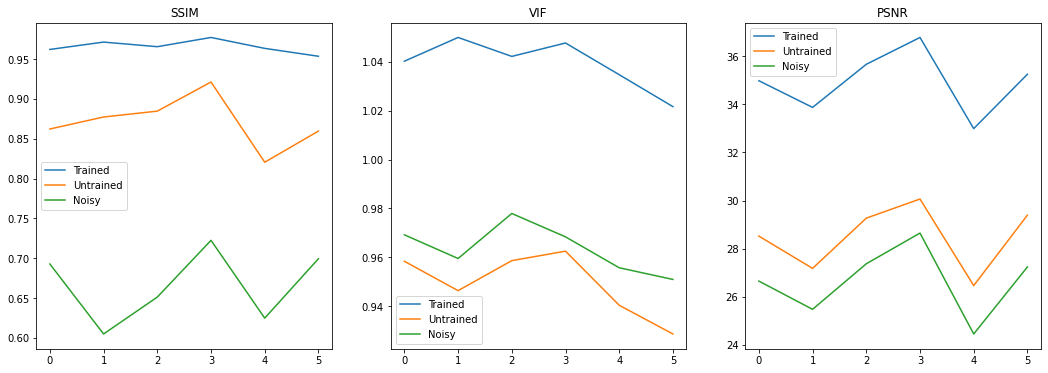

In [9]:
figure, axes = plt.subplots(1, 3, figsize=(18, 6))

trained_ssim = [x.ssim for x in trained_results]
untrained_ssim = [x.ssim for x in untrained_results]
noisy_ssim = [x.ssim for x in noisy_results]
trained_vif = [x.vif for x in trained_results]
untrained_vif = [x.vif for x in untrained_results]
noisy_vif = [x.vif for x in noisy_results]
trained_psnr = [x.psnr for x in trained_results]
untrained_psnr = [x.psnr for x in untrained_results]
noisy_psnr = [x.psnr for x in noisy_results]

axes[0].plot(trained_ssim, label='Trained')
axes[0].plot(untrained_ssim, label='Untrained')
axes[0].plot(noisy_ssim, label='Noisy')
axes[0].legend()
axes[0].set_title('SSIM')

axes[1].plot(trained_vif, label='Trained')
axes[1].plot(untrained_vif, label='Untrained')
axes[1].plot(noisy_vif, label='Noisy')
axes[1].legend()
axes[1].set_title('VIF')

axes[2].plot(trained_psnr, label='Trained')
axes[2].plot(untrained_psnr, label='Untrained')
axes[2].plot(noisy_psnr, label='Noisy')
axes[2].legend()
axes[2].set_title('PSNR')

plt.show()